In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import numpy as np
from data_loader import load_mnist
import matplotlib.pyplot as plt

In [2]:
print("Loading data...")
X_train, y_train, X_test, y_test = load_mnist()
print("MNIST Data Loaded.")

Loading data...
MNIST Data Loaded.


Training Data Shape: (60000, 784)
Test Data Shape: (10000, 784)
Data Type: float32
Min Value: 0.0
Max Value: 1.0

Visualising 5 Random Digits:


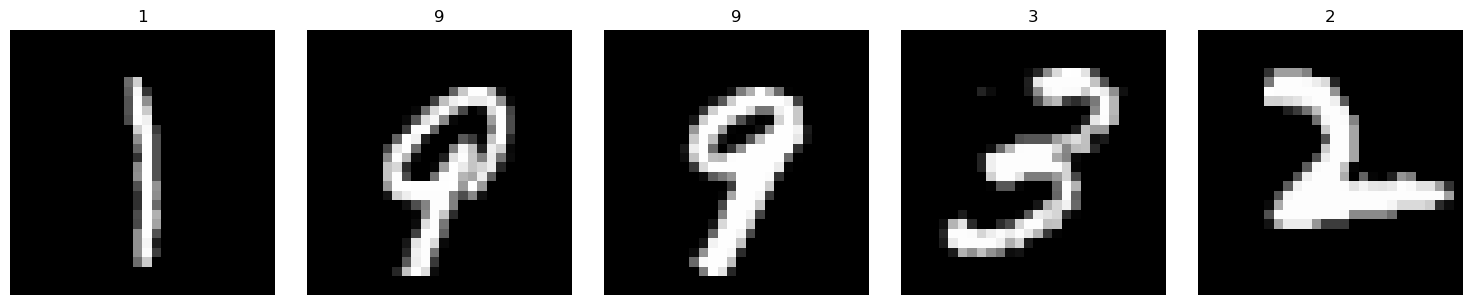

In [3]:
# Check Shapes and Types
print(f"Training Data Shape: {X_train.shape}")  # Should be (60000, 784)
print(f"Test Data Shape: {X_test.shape}")       # Should be (10000, 784)
print(f"Data Type: {X_train.dtype}")            # Should be float32
print(f"Min Value: {X_train.min()}")            # Should be 0.0
print(f"Max Value: {X_train.max()}")            # Should be 1.0

# We need to reshape the flat (784,) vectors back to (28, 28) images to plot
print("\nVisualising 5 Random Digits:")

indices = np.random.randint(0, len(X_train), 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in zip(indices, axes):
    image = X_train[i].reshape(28, 28)
    label = y_train[i]
    
    ax.imshow(image, cmap='gray')
    ax.set_title(f"{label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
from vae import VAE
import time

In [5]:
BATCH_SIZE = 128
EPOCHS = 15
LEARNING_RATE = 0.001
K_LATENT = 32
HIDDEN_LAYER_DIM = 512
ALPHA_HP = 1.0

vae = VAE(n=784, hidden_layer_dim=HIDDEN_LAYER_DIM, k_latent=K_LATENT, learning_rate=LEARNING_RATE)

print(f"Starting training for {EPOCHS} epochs...")
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train_shuffled = X_train[indices]

    # Mini-batch Gradient Descent
    for i in range(0, X_train.shape[0], BATCH_SIZE):
        # Get batch
        X_batch = X_train_shuffled[i : i + BATCH_SIZE]
        
        # Forward Pass
        X_hat, mu, sigma = vae.forward_pass(X_batch)
        
        # Backward Pass
        vae.backward_pass(alpha_hyper_param=ALPHA_HP)
        
        # Update Weights
        # vae.GD_update_step()
        vae.adam_step()

        # Track Loss (MSE + KL) for monitoring
        recon_loss = np.mean(np.sum((X_batch - X_hat)**2, axis=1))
        kl_loss = np.mean(-0.5 * np.sum(1 + np.log(sigma**2) - mu**2 - sigma**2, axis=1))
        total_loss = recon_loss + (ALPHA_HP * kl_loss)
        
        epoch_loss += total_loss
        epoch_recon += recon_loss
        epoch_kl += kl_loss

    # Print average loss for the epoch
    n_batches = X_train.shape[0] / BATCH_SIZE
    avg_loss = epoch_loss / n_batches
    avg_recon = epoch_recon / n_batches
    avg_kl = epoch_kl / n_batches
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Total Loss: {avg_loss:.2f} | Recon Loss: {avg_recon:.2f} | KL Loss: {avg_kl:.2f}")

print(f"Training finished in {time.time() - start_time:.2f} seconds.")

Starting training for 15 epochs...
Epoch 1/15 | Total Loss: 51.27 | Recon Loss: 49.55 | KL Loss: 1.72
Epoch 2/15 | Total Loss: 43.83 | Recon Loss: 41.07 | KL Loss: 2.76
Epoch 3/15 | Total Loss: 41.21 | Recon Loss: 37.83 | KL Loss: 3.38
Epoch 4/15 | Total Loss: 39.27 | Recon Loss: 35.31 | KL Loss: 3.96
Epoch 5/15 | Total Loss: 38.00 | Recon Loss: 33.68 | KL Loss: 4.32
Epoch 6/15 | Total Loss: 37.00 | Recon Loss: 32.40 | KL Loss: 4.60
Epoch 7/15 | Total Loss: 36.21 | Recon Loss: 31.38 | KL Loss: 4.83
Epoch 8/15 | Total Loss: 35.66 | Recon Loss: 30.67 | KL Loss: 4.99
Epoch 9/15 | Total Loss: 35.26 | Recon Loss: 30.16 | KL Loss: 5.10
Epoch 10/15 | Total Loss: 34.93 | Recon Loss: 29.74 | KL Loss: 5.19
Epoch 11/15 | Total Loss: 34.65 | Recon Loss: 29.39 | KL Loss: 5.26
Epoch 12/15 | Total Loss: 34.46 | Recon Loss: 29.12 | KL Loss: 5.33
Epoch 13/15 | Total Loss: 34.24 | Recon Loss: 28.86 | KL Loss: 5.38
Epoch 14/15 | Total Loss: 34.05 | Recon Loss: 28.61 | KL Loss: 5.44
Epoch 15/15 | Total Lo

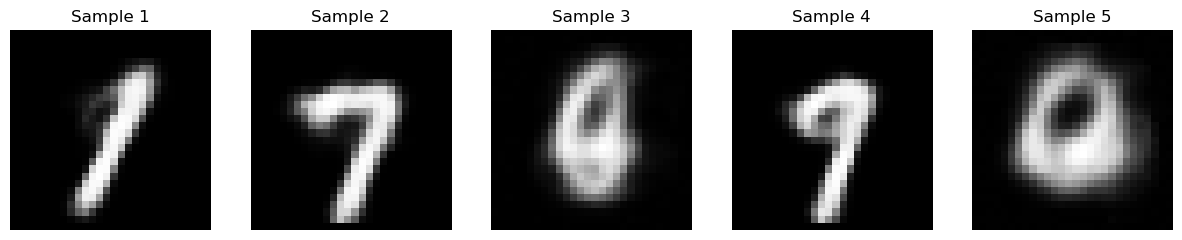

In [6]:
vae.model_infer(num_samples=5)